# AdventureWorks Försäljningsanalys

I denna analys undersöker vi AdventureWorks2019-databasen för att besvara affärsfrågor som ex:
- Produktkategorier och deras försäljnig 
- Försäljningstrender
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [1]:
import pandas as pd 
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np 

user = "sa"
password = quote_plus("WorldWide85")
server = 'localhost,1433'
database = 'AdventureWorks2019'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

### Visualisering 1: Antal produkter per kategori
#### Affärsfråga: Hur många produkter finns i varje kategori?

Tabeller som använts:
Production.ProductCategory
Production.ProductSubcategory
Production.Product

Planering:
JOINA tabellerna
Räkna DISTINCT produkter per kategori
Skapa vertikalt stapeldiagram
Analsera resultatet

Flest produkter: Components (134)
Minst produkter: Accessories (29)


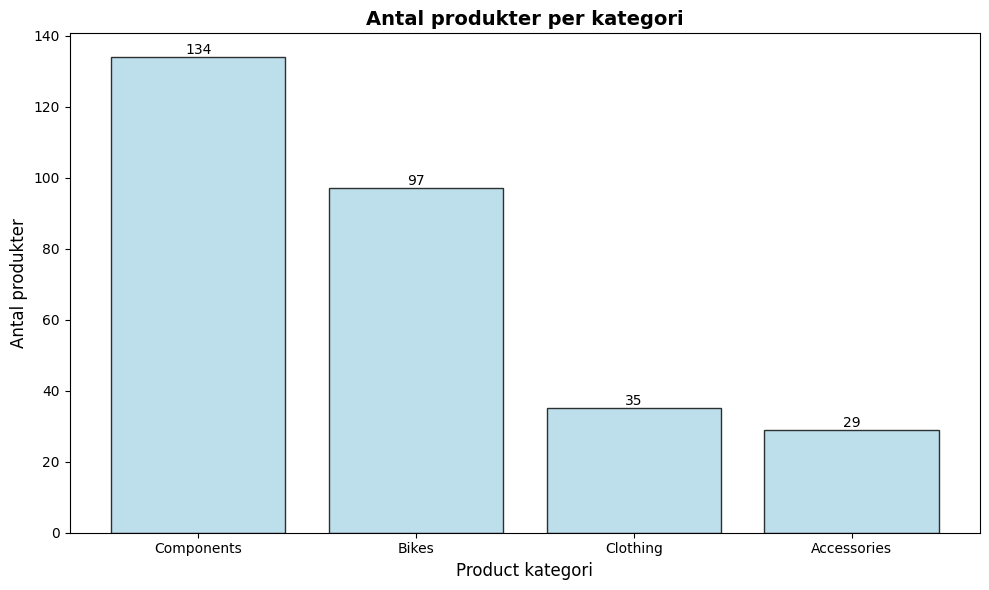

In [10]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
  
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC

"""



df_vis1 = query_df(query_vis1)

max_category = df_vis1.iloc[0]['CategoryName']
max_count = int(df_vis1.iloc[0]['ProductCount'])

min_category = df_vis1.iloc[-1]['CategoryName']
min_count = int(df_vis1.iloc[-1]['ProductCount'])

print(f"Flest produkter: {max_category} ({max_count})")
print(f"Minst produkter: {min_category} ({min_count})")


fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='lightblue', edgecolor='black', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text( 
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )
   


ax.set_xlabel('Product kategori',fontsize=12)
ax.set_ylabel('Antal produkter',fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()




### Insikter - Antal produkter per kategori
Components är största kategorin med 134 produkter.
Accessoarer är minst med 29 produkter.

Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar.
Och att accessoarer kan vara ett utvecklings område.

### Visualisering 2: Total försäljning per produktkategori

#### Affärsfråga: Vilka produktkategorier genererar mest intäkter?

Vi hämtar data från tabellerna SalesOrderDetail, Product, ProductSubcategory och ProductCategory. Vi summerar försäljningen per kategori och sorterar från högst till lägst

Högst försäljning: Bikes (94,651,173)
Lägst försäljning: Accessories (1,272,073)


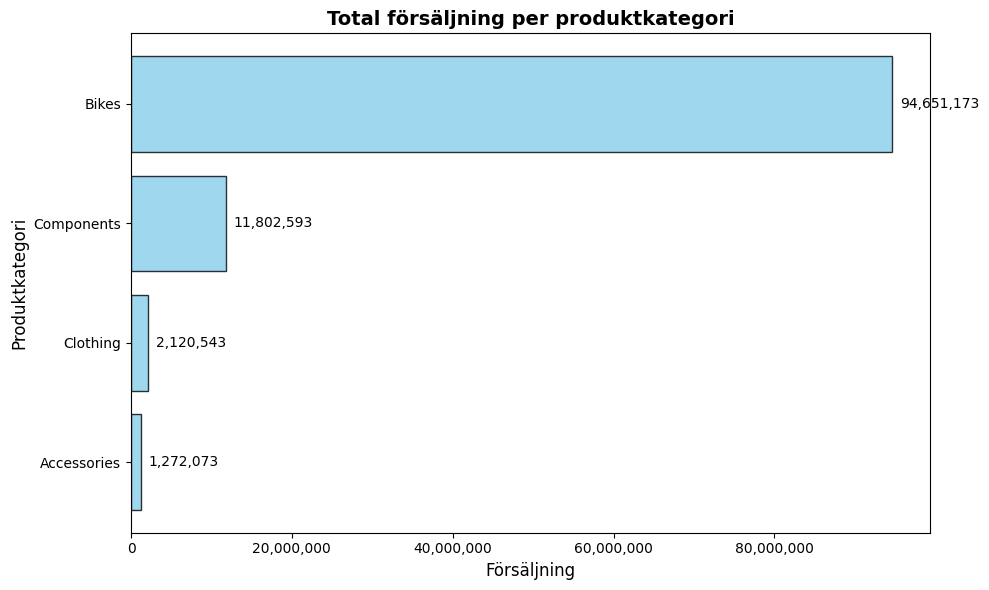

In [11]:
query_vis2 = """ 
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM 
    Sales.SalesOrderDetail sod
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID

GROUP BY 
    pc.Name
ORDER BY
    TotalSales DESC;
"""

df_vis2 = query_df(query_vis2)

max_category = df_vis2.iloc[0]['CategoryName']
max_sales = df_vis2.iloc[0]['TotalSales']

min_category = df_vis2.iloc[-1]['CategoryName']
min_sales = df_vis2.iloc[-1]['TotalSales']

print(f"Högst försäljning: {max_category} ({max_sales:,.0f})")
print(f"Lägst försäljning: {min_category} ({min_sales:,.0f})")


fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(
    df_vis2['CategoryName'], 
    df_vis2['TotalSales'], 
    color='skyblue', 
    edgecolor='black', 
    alpha=0.8
)

ax.invert_yaxis()

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

for bar in bars:
    width = bar.get_width()
    ax.text(
        width + max_sales*0.01, 
        bar.get_y() + bar.get_height()/2,
        f'{width:,.0f}',
        va='center',
        fontsize=10
    )


ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')
ax.set_xlabel('Försäljning', fontsize=12)
ax.set_ylabel('Produktkategori', fontsize=12)

plt.tight_layout()
plt.show()


### Insikter - Totalförsäljning per produktkategori

Stapeldiagrammet visar tydligt vilken produktkategori som genererar mest och minst försäljning.  

Kategorin **Bikes** har högst total försäljning med 94,651,173 sålda.  
Kategorin **Accessories** har lägst total försäljning med 1,272,072 sålda.  

Detta hjälper oss att förstå vilka produktområden som bidrar mest till intäkterna.


### Visualisering 3: Försäljningstrend per månad

#### Affärsfråga: Hur har försäljningen utvecklats över tid? Finns det säsongsvariationer eller en generell trend?

Vi hämtar försäljningsdata från Sales.SalesOrderHeader, aggregerar total försäljning per månad och sorterar kronologiskt. Visualiserar sedan med ett linjediagram för att visa trenden.


Högst försäljning: 2014-03 (8,097,036)
Lägst försäljning: 2014-06 (54,151)


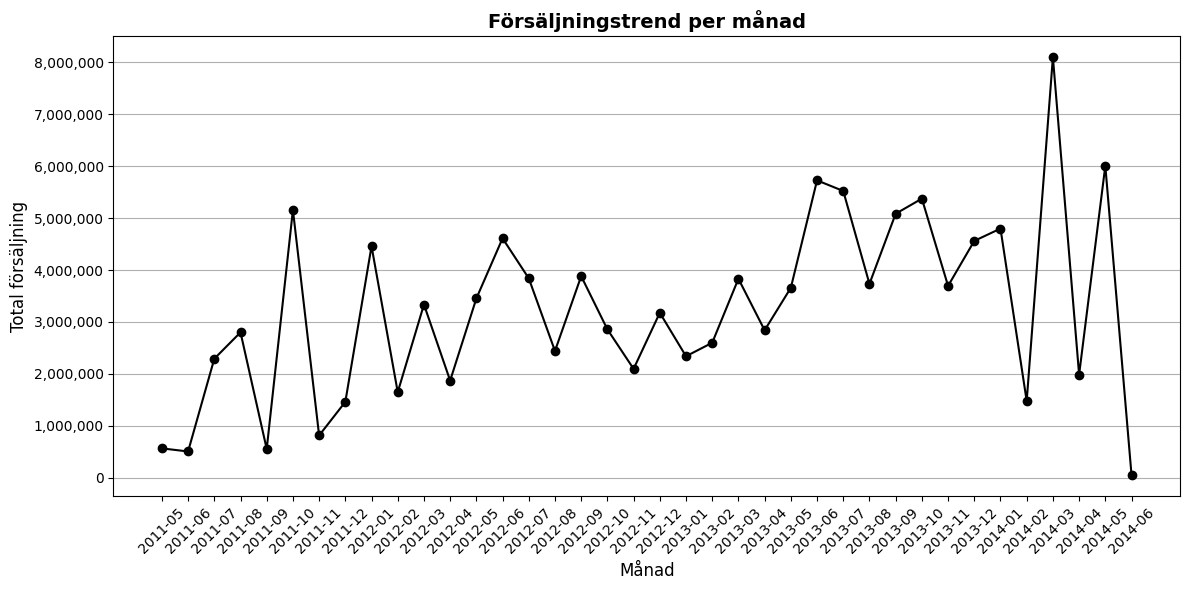

In [12]:
query_vis3 = """
SELECT 
    CAST(YEAR(OrderDate) AS VARCHAR(4)) + '-' + RIGHT('0' + CAST(MONTH(OrderDate) AS VARCHAR(2)), 2) AS YearMonth,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY YEAR(OrderDate), MONTH(OrderDate);
"""

df_vis3 = query_df(query_vis3)


fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df_vis3['YearMonth'], df_vis3['TotalSales'], marker='o', linestyle='-', color='black')

ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight='bold')
ax.set_xlabel('Månad', fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

max_row = df_vis3.loc[df_vis3['TotalSales'].idxmax()]
min_row = df_vis3.loc[df_vis3['TotalSales'].idxmin()]

print(f"Högst försäljning: {max_row['YearMonth']} ({max_row['TotalSales']:,.0f})")
print(f"Lägst försäljning: {min_row['YearMonth']} ({min_row['TotalSales']:,.0f})")



plt.tight_layout()
plt.show()






### Insikter - Försäljningstrend över tid

Visualiseringen visar hur försäljningen förändras varje månad.  
Vi kan identifiera månader med högst och lägst försäljning, samt se om det finns en uppåtgående eller nedåtgående trend. Säsongsvariationer blir också tydliga.

Högt försäljning Mars 2014 och lägst Juni 2014.


### Visualisering 4: Försäljning och antal ordrar per år

#### Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?

Data hämtas från tabellen Sales.SalesOrderHeader.
Försäljningen summeras per år och antalet ordrar räknas.
Resultatet grupperas och sorteras kronologiskt för att kunna jämföra utvecklingen över tid.

Högst försäljning: 2013 (48,965,888)


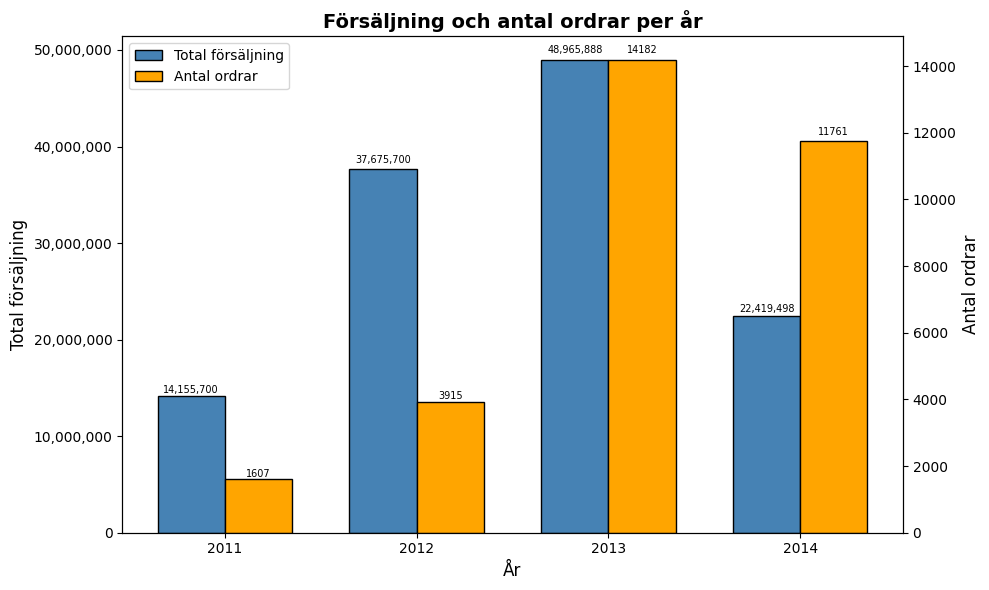

In [13]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS OrderYear,
    SUM(TotalDue) AS TotalSales,
    COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;
"""


df_vis4 = query_df(query_vis4)


x = np.arange(len(df_vis4))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()  


bars1 = ax1.bar(x - width/2, df_vis4['TotalSales'], width, label='Total försäljning', color='steelblue',edgecolor='black',)
bars2 = ax2.bar(x + width/2, df_vis4['OrderCount'], width, label='Antal ordrar', color='orange', edgecolor='black',)


ax1.set_title('Försäljning och antal ordrar per år', fontsize=14, fontweight='bold')
ax1.set_xlabel('År', fontsize=12)
ax1.set_ylabel('Total försäljning', fontsize=12)
ax2.set_ylabel('Antal ordrar', fontsize=12)


ax1.set_xticks(x)
ax1.set_xticklabels(df_vis4['OrderYear'])


ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

max_row = df_vis4.loc[df_vis4['TotalSales'].idxmax()]
print(f"Högst försäljning: {int(max_row['OrderYear'])} ({max_row['TotalSales']:,.0f})")




for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height*1.01, f'{height:,.0f}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height*1.01, f'{height}', ha='center', va='bottom', fontsize=7)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()





### Insikter - Försäljning och antal ordrar per år

År 2011, 2012 och 2013 ökade både antal ordrar och total försäljning. Under 2014 är det en liten nedgång i både försäljning och antal ordrar. År 1013 är både ordrar och försäljning högst.



### Visualisering 5: Top 10 produkter efter försäljning  
 
#### Affärsfråga: Vilka 10 produkter genererar mest försäljning?

Hämtade TotalSales per produkt från SalesOrderDetail, summerade, sorterade och valde topp 10


Top 1 produkt: Mountain-200 Black, 38 (4,400,593)


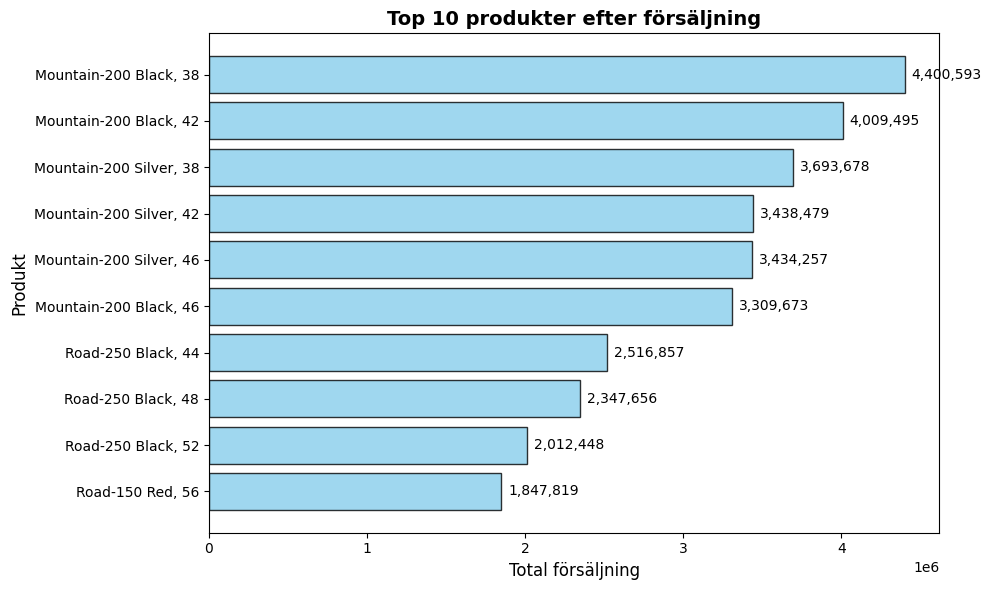

In [7]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProductName,
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail AS sod
INNER JOIN Production.Product AS p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory AS psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory AS pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY p.Name, pc.Name
ORDER BY TotalSales DESC;
"""

df_vis5 = query_df(query_vis5)

top_product = df_vis5.iloc[0]['ProductName']
top_sales = df_vis5.iloc[0]['TotalSales']
print(f"Top 1 produkt: {top_product} ({top_sales:,.0f})")


fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis5['ProductName'], df_vis5['TotalSales'], color='skyblue', edgecolor='black', alpha=0.8)
ax.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax.text(width + top_sales*0.01, bar.get_y() + bar.get_height()/2, f'{width:,.0f}', va='center', fontsize=10)

ax.set_title('Top 10 produkter efter försäljning', fontsize=14, fontweight='bold')
ax.set_xlabel('Total försäljning', fontsize=12)
ax.set_ylabel('Produkt', fontsize=12)

plt.tight_layout()
plt.show()


### Insikter - Top 10 produkter

Mountain-200 Black, 38 är produkten med högst totala försäljningsvärde: 4,400,593.



### Visualisering 6: Skillnader i försäljning

#### Affärsfråga: Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Data har hämtats från tabellerna Sales.SalesOrderHeader, Sales.SalesTerritory och Sales.Customer.  
För varje region har total försäljning summerats och antalet unika kunder räknats.  
Resultatet visas med ett grupperat stapeldiagram där varje region jämförs utifrån försäljning och kundantal.

Starkast region: Southwest (27.2 Mkr, 4565 kunder)
Svagast region: Germany (5.5 Mkr, 1812 kunder)


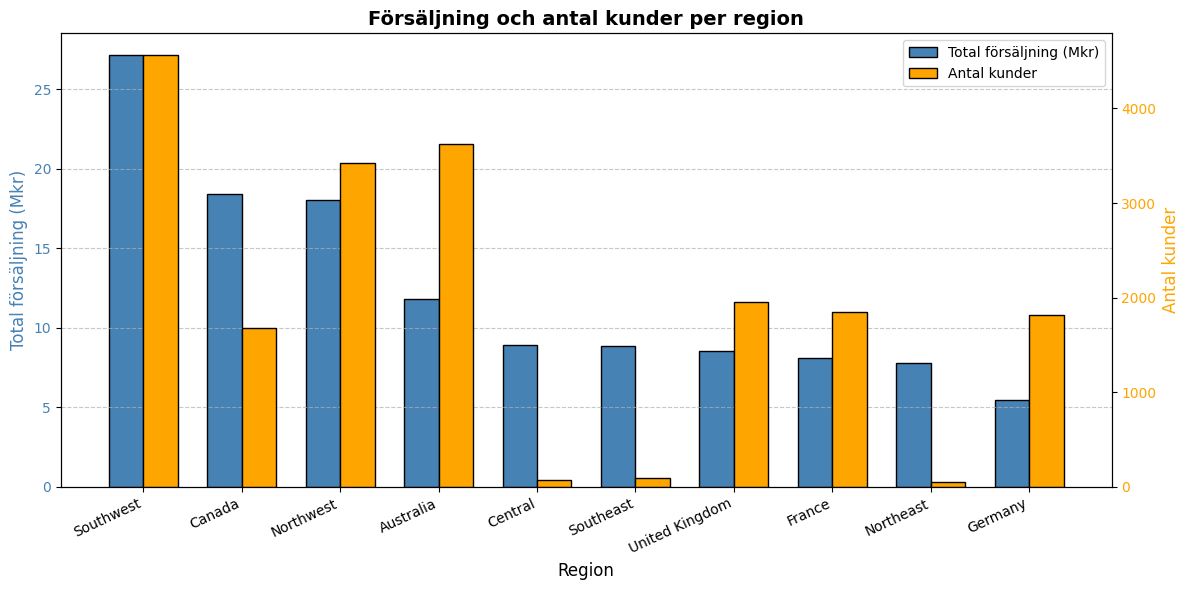

In [8]:
query_vis6 = """
SELECT
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT soh.CustomerID) AS CustomerCount
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st 
    ON soh.TerritoryID = st.TerritoryID
INNER JOIN Sales.Customer c 
    ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC;
"""

df_vis6 = query_df(query_vis6)

x = np.arange(len(df_vis6))
width = 0.35

max_row = df_vis6.iloc[0]
min_row = df_vis6.iloc[-1]
print(f"Starkast region: {max_row['Region']} ({max_row['TotalSales']/1_000_000:,.1f} Mkr, {max_row['CustomerCount']} kunder)")
print(f"Svagast region: {min_row['Region']} ({min_row['TotalSales']/1_000_000:,.1f} Mkr, {min_row['CustomerCount']} kunder)")

fig, ax1 = plt.subplots(figsize=(12,6))

bars1 = ax1.bar(x - width/2, 
        df_vis6['TotalSales']/1_000_000, 
        width, color='steelblue', 
        edgecolor='black',
        label='Total försäljning (Mkr)')
ax1.set_ylabel('Total försäljning (Mkr)', fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, 
        df_vis6['CustomerCount'], 
        width, color='orange', 
        edgecolor='black',
        label='Antal kunder')
ax2.set_ylabel('Antal kunder', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.set_title('Försäljning och antal kunder per region', fontsize=14, fontweight='bold')
ax1.set_xlabel('Region', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis6['Region'], rotation=25, ha='right')

ax1.grid(axis='y', linestyle='--', alpha=0.7)

handles = [bars1, bars2]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()


### Insikt: Försäljning och antal kunder per region

- Regionen med högst total försäljning är Sydväst och har samtidigt flest kunder jämfört med övriga regioner.  
- Regionen med lägst försäljning är Tyskland.  
- Generellt syns ett mönster där högre försäljning inte alltid innebär fler kunder.


### Visualisering 7: Genomsnitt ordervärde per region och kundtyp.

#### Affärsfråga: Vilka regioner har högst och lägst genomsnittligt ordervärde, och skiljer det sig mellan privatkunder och företagskunder?
 
Orderdata har hämtats från AdventureWorks-databasen.  
Genomsnittligt ordervärde har beräknats som total försäljning dividerat med antal ordrar per region.  
Resultatet är uppdelat på kundtyp: Individual och Stor.

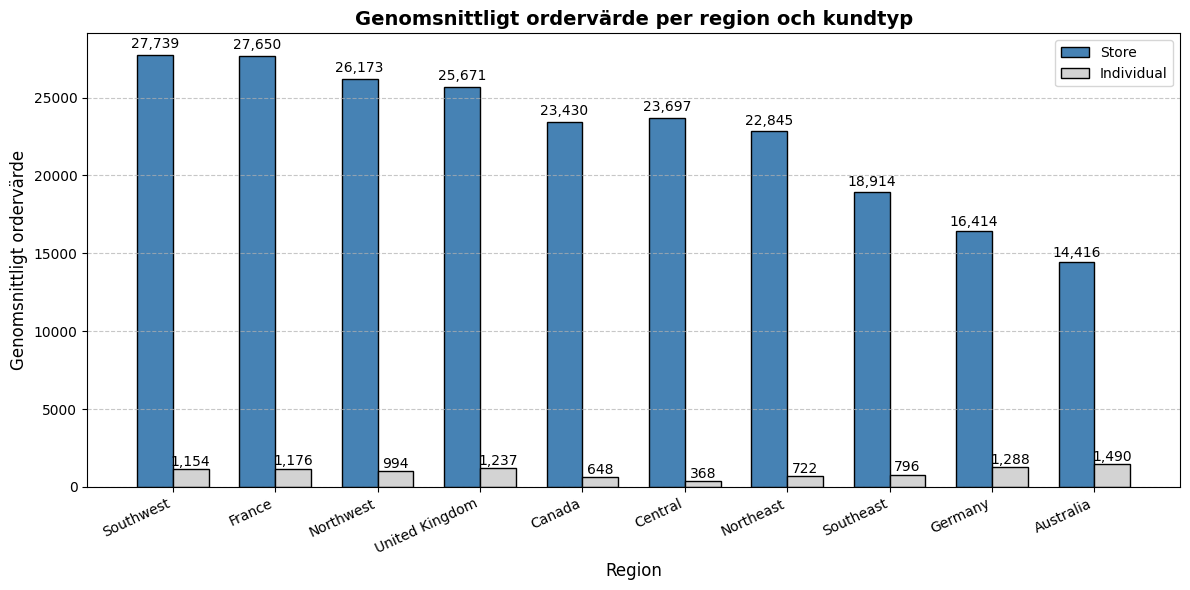

Högst genomsnittligt ordervärde (Store): Southwest (27,739)
Högst genomsnittligt ordervärde (Individual): Australia (1,490)


In [9]:
query_vis7 = """
SELECT 
    st.Name AS Region,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END AS CustomerType,
    SUM(soh.TotalDue)/COUNT(soh.SalesOrderID) AS AvgOrderValue
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
INNER JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
GROUP BY 
    st.Name,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END
"""

df_vis7 = query_df(query_vis7)

pivot_df = df_vis7.pivot(index='Region', columns='CustomerType', values='AvgOrderValue').fillna(0)
pivot_df['Total'] = pivot_df['Store'] + pivot_df['Individual']
pivot_df = pivot_df.sort_values('Total', ascending=False).reset_index()

x = np.arange(len(pivot_df))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))

bars1 = ax.bar(x - width/2, pivot_df['Store'], width, label='Store', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, pivot_df['Individual'], width, label='Individual', color='lightgrey', edgecolor='black')

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height*1.01, f'{height:,.0f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height*1.01, f'{height:,.0f}', ha='center', va='bottom')

ax.set_title('Genomsnittligt ordervärde per region och kundtyp', fontsize=14, fontweight='bold')
ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Genomsnittligt ordervärde', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(pivot_df['Region'], rotation=25, ha='right')

ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

max_store = pivot_df.loc[pivot_df['Store'].idxmax()]
max_individual = pivot_df.loc[pivot_df['Individual'].idxmax()]

print(f"Högst genomsnittligt ordervärde (Store): {max_store['Region']} ({max_store['Store']:,.0f})")
print(f"Högst genomsnittligt ordervärde (Individual): {max_individual['Region']} ({max_individual['Individual']:,.0f})")


### Insikt - Genomsnittligt ordervärde per region och kundtyp

- Regionen med högst genomsnittligt ordervärde är Sydväst.  
- Store-kunder har alltid högre ordervärde än individual-kunder, vilket tyder på större köpvolymer per order för företag.  
- Individual-kunderna ligger mer eller mindre på samma nivå men det varierar lite mer mellan store-kunderna i de olika regionerna.
 




## Sammanfattning av AdventureWorks Försäljningsanalys

### Huvudsakliga fynd
Försäljningen och utbudet av produkter är ganska ojämnt mellan olika kategorier, produkter och regioner. Vissa kategorier och produkter står för mestadelen av intäkterna, medan andra säljer ganska lite. Försäljningen går upp och ner under året, och företagskunder brukar lägga större beställningar än privatkunder. Vissa regioner har hög försäljning trots få kunder, medan andra har många kunder men lägre intäkter per order.

 
